Mitq tutorial: https://mitiq.readthedocs.io/en/stable/examples/ibmq-backends.html

# Imports

In [1]:
import numpy as np

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise

from utils.pce_vs_zne_utils import *

from qiskit import *
from qiskit.quantum_info import Clifford, random_clifford
from qiskit.synthesis import synth_clifford_full
from qiskit.quantum_info import hellinger_fidelity as hf

from utils.pauli_checks import convert_to_PCS_circ # new util
from utils.pce_vs_zne_utils import run_zne_estimator

from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

from utils.pce_vs_zne_utils import *

from qiskit_ibm_runtime.fake_provider import *
from qiskit_aer import AerSimulator

np.set_printoptions(precision=6, edgeitems=10, linewidth=150, suppress=True)

#### Backend settings

In [2]:
USE_REAL_HARDWARE = False

In [6]:
# Fake backend noise model
# fake_backend = FakeMelbourneV2()
# noise_model = noise.NoiseModel.from_backend(fake_backend)

# Custom nosie model
prob_1 = 1e-3 # 1-qubit gate
prob_2 = 1e-2  # 2-qubit gate

error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# test set
# noise_model.add_all_qubit_quantum_error(error_1, ['z', 'y', 'x', 's', 'sdg', 'h'])
# noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

In [7]:
service = QiskitRuntimeService()
print(service.instances())

['research-credits/100462/main', 'ibm-q/open/main']


In [8]:
# print(QiskitRuntimeService.saved_accounts())
if QiskitRuntimeService.saved_accounts() and USE_REAL_HARDWARE:
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)
    noise_model = False
else:
    # backend = AerSimulator()
    backend = AerSimulator(noise_model=noise_model)
    # backend = AerSimulator.from_backend(fake_backend)

print(backend)

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['u2', 'u3', 'sx', 'x', 'cx', 'u1']>)


# Setup

In [9]:
# circuit parameters
num_qubits = 6
num_circs = 5
circuit_depth = 10

# observable we're estimating
pauli_string = 'Z' * num_qubits

# pce parameters
num_checks = num_qubits//2
# num_checks = num_qubits
print(f"num_checks = {num_checks}")
num_checks_to_fit = num_checks
extrap_checks = range(num_checks_to_fit + 1, num_qubits + 1)
only_Z_checks = True

# number of shots per check layer
shots_per_check = 10_000

# zne parameters
verbose = True

num_checks = 3


5


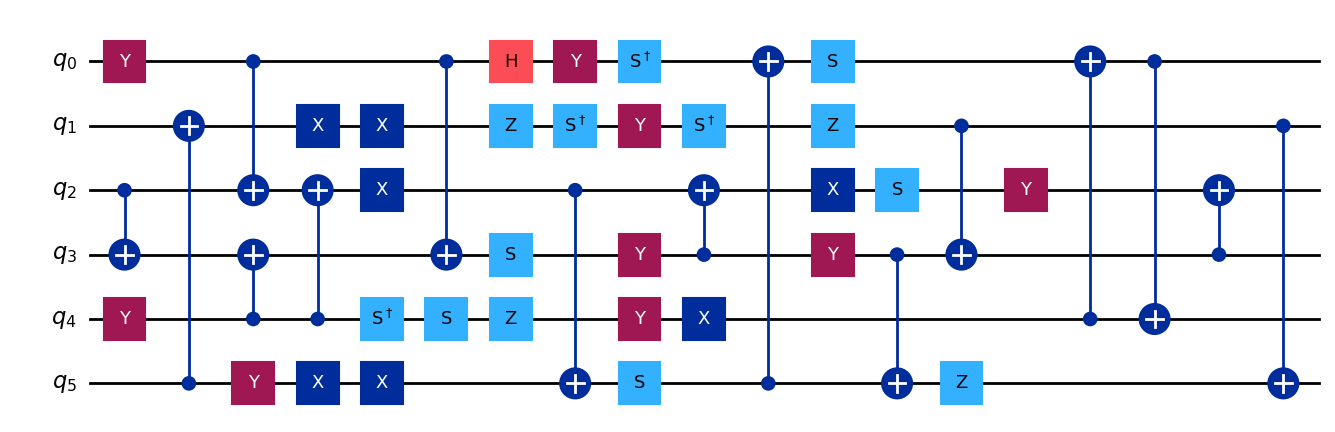

In [10]:
# cliff_circs = random_cliff_mirror_circs(num_qubits, num_circs)
cliff_circs = random_cliff_circs(num_qubits, circuit_depth, num_circs, pauli_string)
print(len(cliff_circs))
cliff_circs[-1].draw("mpl", fold=-1)

In [11]:
ideal_expectations = []
for circ in cliff_circs:
    ideal_expect = get_ideal_expectation(circ, pauli_string)
    ideal_expectations.append(ideal_expect)

print(ideal_expectations)

[(-0.9999999999999996+0j), (-0.9999999999999996+0j), (0.9999999999999996+0j), (0.9999999999999998+0j), (-0.9999999999999998+0j)]


In [12]:
pcs_circs = [[] for _ in range(num_circs)]
signs_list = [[] for _ in range(num_circs)]

for i, circ in enumerate(cliff_circs):
    print("i =", i+1, "out of", num_circs)
    for check_id in range(1, num_checks + 1):
        print("check_id =", check_id)
        sign, pcs_circ = convert_to_PCS_circ(circ, num_qubits, check_id, only_Z_checks=only_Z_checks, barriers=True)
        pcs_circs[i].append(pcs_circ)
        signs_list[i].append(sign)

print(len(pcs_circs))
print(len(pcs_circs[0]))
# print(signs_list)

# pcs_circs[0][0].draw("mpl", fold=-1)

i = 1 out of 5
check_id = 1
trying  ['I', 'I', 'I', 'I', 'I', 'Z']
Found check 1: +1IZZIII, +1IIIIIZ
Required number of checks found.
p1_list =  [['+1IZZIII', '+1IIIIIZ']]
check_id = 2
trying  ['I', 'I', 'I', 'I', 'I', 'Z']
Found check 1: +1IZZIII, +1IIIIIZ
trying  ['I', 'I', 'I', 'I', 'Z', 'I']
Found check 2: -1ZIZZZI, +1IIIIZI
Required number of checks found.
p1_list =  [['+1IZZIII', '+1IIIIIZ'], ['-1ZIZZZI', '+1IIIIZI']]
check_id = 3
trying  ['I', 'I', 'I', 'I', 'I', 'Z']
Found check 1: +1IZZIII, +1IIIIIZ
trying  ['I', 'I', 'I', 'I', 'Z', 'I']
Found check 2: -1ZIZZZI, +1IIIIZI
trying  ['I', 'I', 'I', 'Z', 'I', 'I']
Found check 3: +1ZIIYXX, +1IIIZII
Required number of checks found.
p1_list =  [['+1IZZIII', '+1IIIIIZ'], ['-1ZIZZZI', '+1IIIIZI'], ['+1ZIIYXX', '+1IIIZII']]
i = 2 out of 5
check_id = 1
trying  ['I', 'I', 'I', 'I', 'I', 'Z']
Found check 1: -1IIIIIX, +1IIIIIZ
Required number of checks found.
p1_list =  [['-1IIIIIX', '+1IIIIIZ']]
check_id = 2
trying  ['I', 'I', 'I', 'I', 'I'

# Run Tests

In [15]:
# Updated ZNE tests: sweeping over methods, scale factor sets, and folding techniques

# List of ZNE methods
zne_methods_list = ["linear", "richardson"]

# List of scale factor sets to test
scale_factors_list = [
    [1, 1.1, 1.2],
    [1, 3, 5],
    [1, 2, 3, 4, 5],
    [1, 1.1, 1.2, 1.3, 1.4]
    # You can add additional scale factor sets here
]

# List of folding techniques (global and local)
# fold_methods_list = [zne.scaling.fold_global, zne.scaling.fold_gates_at_random]
fold_methods_list = [zne.scaling.fold_gates_at_random]

# Dictionary to store the averaged errors
zne_avg_errors = {}

# Iterate over each ZNE method, scale factors set, and fold method
for zne_m in zne_methods_list:
    for scale_factors in scale_factors_list:
        # Automatically skip tests if using Richardson with non-integer scale factors.
        if zne_m == "richardson" and not all(isinstance(sf, int) for sf in scale_factors):
            print(f"Skipping test for method: {zne_m}, scale factors: {scale_factors}"
                  "because partial folding (non-integer scale factors) is not supported with Richardson extrapolation.")
            continue

        for fold_method in fold_methods_list:
            print(f"Running ZNE tests with method: {zne_m}, scale factors: {scale_factors}, fold method: {fold_method.__name__}")
            zne_abs_errors = []

            zne_shots_per_circ = (shots_per_check * num_checks_to_fit) // len(scale_factors)
            print(f"ZNE shots per circuit: {zne_shots_per_circ}")

            # Run the circuits for the current combination
            for i, circ in enumerate(cliff_circs):
                zne_exp = mitigate_zne(
                    circ,
                    backend,
                    pauli_string,
                    shots = zne_shots_per_circ,
                    method=zne_m,
                    scale_factors=scale_factors,
                    fold_method=fold_method,
                )
                print(f"ZNE ({zne_m}, scale_factors={scale_factors}, fold_method={fold_method.__name__}) mitigated exp for {pauli_string}: {zne_exp}")
                print(f"Ideal expectation = {ideal_expectations[i]}")

                abs_error = np.abs(ideal_expectations[i] - zne_exp)
                zne_abs_errors.append(abs_error)

            avg_error = np.mean(zne_abs_errors)
            key = f"ZNE_{zne_m}_{'_'.join(str(s) for s in scale_factors)}_{fold_method.__name__}"
            zne_avg_errors[key] = avg_error
            print(f"Average absolute error for {key}: {avg_error:.5f}\n")

print("Final ZNE results:")
print(zne_avg_errors)

Running ZNE tests with method: linear, scale factors: [1, 1.1, 1.2], fold method: fold_gates_at_random
ZNE shots per circuit: 10000
>>> Circuit ops (ISA): OrderedDict({'cx': 21, 'u1': 14, 'u2': 2, 'x': 2})
>>> Circuit ops (ISA): OrderedDict({'cx': 23, 'u1': 16, 'u2': 2, 'x': 2})
>>> Circuit ops (ISA): OrderedDict({'cx': 25, 'u1': 18, 'u2': 2, 'x': 2})
ZNE (linear, scale_factors=[1, 1.1, 1.2], fold_method=fold_gates_at_random) mitigated exp for ZZZZZZ: -0.9540666666666663
Ideal expectation = (-0.9999999999999996+0j)
>>> Circuit ops (ISA): OrderedDict({'cx': 16, 'u1': 15, 'u3': 6, 'x': 4, 'u2': 3})
>>> Circuit ops (ISA): OrderedDict({'cx': 18, 'u1': 17, 'u3': 6, 'x': 4, 'u2': 3})
>>> Circuit ops (ISA): OrderedDict({'u1': 19, 'cx': 18, 'u3': 6, 'u2': 5, 'x': 4})
ZNE (linear, scale_factors=[1, 1.1, 1.2], fold_method=fold_gates_at_random) mitigated exp for ZZZZZZ: -0.9992333333333329
Ideal expectation = (-0.9999999999999996+0j)
>>> Circuit ops (ISA): OrderedDict({'cx': 18, 'u1': 13, 'x': 6,

In [14]:
# List of extrapolation methods to test: linear and exponential
extrapolation_methods = ["linear", "exponential"]

# Dictionary to store the averaged errors for PCE
pce_avg_errors = {}

# Loop over each extrapolation method
for ext_method in extrapolation_methods:
    pce_abs_errors = []
    print(f"\nProcessing PCE with extrapolation method: {ext_method}\n")

    # Loop over each circuit
    for i, cliff_circ in enumerate(cliff_circs):
        print(f"Processing PCE for circuit {i+1} out of {num_circs}")
        expectation_values = []

        # Loop over each number of checks for the current circuit
        for j in range(num_checks):
            pcs_circ = pcs_circs[i][j]
            signs = signs_list[i][j]
            expectation_value = ibmq_executor_pcs(
                pcs_circ,
                backend=backend,
                pauli_string=pauli_string,
                num_qubits=num_qubits,
                signs=signs
            )
            expectation_values.append(expectation_value)

        print(f"Expectation values: {expectation_values}")

        # Extrapolate the expectation values using the current extrapolation method
        extrapolated_values, poly = extrapolate_checks(
            num_checks_to_fit,
            extrap_checks,
            expectation_values,
            method=ext_method
        )
        pce_exp = extrapolated_values[-1]

        print(f"PCE exp for {pauli_string} using {ext_method}: {pce_exp}")
        print(f"Ideal expectation = {ideal_expectations[i]}")

        abs_error = np.abs(ideal_expectations[i] - pce_exp)
        print(f"Absolute error = {abs_error}\n")
        pce_abs_errors.append(abs_error)

    # Compute average absolute error for the current extrapolation method
    pce_avg_error = np.mean(pce_abs_errors)
    key = f"PCE_{ext_method}"
    pce_avg_errors[key] = pce_avg_error
    print(f"Average absolute error for {key}: {pce_avg_error:.5f}\n")

print("Final PCE results:")
print(pce_avg_errors)


Processing PCE with extrapolation method: linear

Processing PCE for circuit 1 out of 5
>>> Circuit ops (ISA): OrderedDict({'cx': 24, 'u1': 14, 'u2': 10, 'measure': 7, 'barrier': 3, 'x': 2})
>>> Circuit ops (ISA): OrderedDict({'cx': 29, 'u2': 22, 'u1': 14, 'measure': 8, 'barrier': 5, 'x': 2})
>>> Circuit ops (ISA): OrderedDict({'cx': 34, 'u2': 28, 'u1': 16, 'measure': 9, 'barrier': 7, 'x': 2})
Expectation values: [-0.8531331592689295, -0.9234687833195119, -0.9259542959274862]
PCE exp for ZZZZZZ using linear: -1.0464943528224222
Ideal expectation = (-0.9999999999999996+0j)
Absolute error = 0.04649435282242265

Processing PCE for circuit 2 out of 5
>>> Circuit ops (ISA): OrderedDict({'cx': 18, 'u1': 15, 'u2': 7, 'measure': 7, 'u3': 6, 'x': 4, 'barrier': 3})
>>> Circuit ops (ISA): OrderedDict({'cx': 23, 'u2': 19, 'u1': 15, 'measure': 8, 'u3': 6, 'barrier': 5, 'x': 4})
>>> Circuit ops (ISA): OrderedDict({'u2': 27, 'cx': 26, 'u1': 15, 'measure': 9, 'barrier': 7, 'u3': 6, 'x': 4})
Expectati

/Users/quinn.langfitt/git/PCS_ZNE/utils/pce_vs_zne_utils.py:481: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_model, check_numbers, y_data, p0=initial_guess,
/Users/quinn.langfitt/git/PCS_ZNE/utils/pce_vs_zne_utils.py:481: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_model, check_numbers, y_data, p0=initial_guess,


>>> Circuit ops (ISA): OrderedDict({'cx': 31, 'u1': 17, 'u2': 16, 'measure': 8, 'x': 6, 'barrier': 5, 'u3': 3})
>>> Circuit ops (ISA): OrderedDict({'cx': 38, 'u2': 32, 'u1': 17, 'measure': 9, 'barrier': 7, 'x': 6, 'u3': 3})
Expectation values: [0.9359534206695779, 0.9401945478563708, 0.9441872768152361]
PCE exp for ZZZZZZ using exponential: 0.9548163107771555
Ideal expectation = (0.9999999999999996+0j)
Absolute error = 0.0451836892228441

Processing PCE for circuit 4 out of 5
>>> Circuit ops (ISA): OrderedDict({'cx': 27, 'u2': 15, 'u1': 9, 'measure': 7, 'u3': 4, 'x': 4, 'barrier': 3})
>>> Circuit ops (ISA): OrderedDict({'cx': 32, 'u2': 21, 'u1': 13, 'measure': 8, 'barrier': 5, 'u3': 4, 'x': 4})


/Users/quinn.langfitt/git/PCS_ZNE/utils/pce_vs_zne_utils.py:481: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_model, check_numbers, y_data, p0=initial_guess,
/Users/quinn.langfitt/git/PCS_ZNE/utils/pce_vs_zne_utils.py:481: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_model, check_numbers, y_data, p0=initial_guess,


>>> Circuit ops (ISA): OrderedDict({'cx': 34, 'u2': 27, 'u1': 13, 'measure': 9, 'barrier': 7, 'u3': 4, 'x': 4})
Expectation values: [0.8741788219574658, 0.8690050107372942, 0.872239550842171]
PCE exp for ZZZZZZ using exponential: 0.8697680996578218
Ideal expectation = (0.9999999999999998+0j)
Absolute error = 0.13023190034217802

Processing PCE for circuit 5 out of 5
>>> Circuit ops (ISA): OrderedDict({'cx': 19, 'u1': 17, 'u3': 9, 'u2': 7, 'x': 7, 'measure': 7, 'barrier': 3})
>>> Circuit ops (ISA): OrderedDict({'cx': 22, 'u1': 17, 'u2': 15, 'u3': 9, 'measure': 8, 'x': 7, 'barrier': 5})
>>> Circuit ops (ISA): OrderedDict({'u2': 29, 'cx': 28, 'u1': 17, 'u3': 9, 'measure': 9, 'barrier': 7, 'x': 7})
Expectation values: [-0.9105902777777778, -0.9101527403414196, -0.9310175524733031]
PCE exp for ZZZZZZ using exponential: -0.9580941348337291
Ideal expectation = (-0.9999999999999998+0j)
Absolute error = 0.041905865166270706

Average absolute error for PCE_exponential: 0.05634

Final PCE results

/Users/quinn.langfitt/git/PCS_ZNE/utils/pce_vs_zne_utils.py:481: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_model, check_numbers, y_data, p0=initial_guess,


In [16]:
# Combine all errors in a single dictionary
avg_errors = zne_avg_errors.copy()
avg_errors.update(pce_avg_errors)

print(avg_errors)

{'ZNE_linear_1_1.1_1.2_fold_gates_at_random': 0.04065999999999992, 'ZNE_linear_1_3_5_fold_gates_at_random': 0.05667333333333298, 'ZNE_linear_1_2_3_4_5_fold_gates_at_random': 0.05995999999999959, 'ZNE_linear_1_1.1_1.2_1.3_1.4_fold_gates_at_random': 0.017106666666666805, 'ZNE_richardson_1_3_5_fold_gates_at_random': 0.012395000000000045, 'ZNE_richardson_1_2_3_4_5_fold_gates_at_random': 0.20640000000000347, 'PCE_linear': 0.0447785456574757, 'PCE_exponential': 0.05633730048305061}


In [17]:
circ_folder = "rand_cliffs_new"
file_name = f"avg_errors_n={num_qubits}_d={circuit_depth}_num_circs={num_circs}_num_samp={10_000}.csv"
save_avg_errors(circ_folder, file_name, avg_errors, overwrite=True)

Results successfully saved to data_PCE_vs_ZNE/rand_cliffs_new/avg_errors_n=6_d=10_num_circs=5_num_samp=10000.csv


# Plots

In [18]:
# Set the directory and parameters to match your saved CSV file.
data_dir = "data_PCE_vs_ZNE/rand_cliffs_new"
num_circs = 6
depth = 10
num_samples = 10_000

# Load the saved average errors.
data = load_avg_errors(data_dir, num_circs=num_circs, num_samples=num_samples, depth=depth)
print("Loaded data:")
print(data)

# Plot the data.
plot_save_path = os.path.join(data_dir, f"error_plot_num_circs={num_circs}_num_samps={num_samples}_d={depth}.png")
plot_avg_errors_by_qubit(data, num_samples=num_samples, num_circs=num_circs, depth=depth, save_path=plot_save_path)

Loaded data:
{}


ZeroDivisionError: float division by zero

In [ ]:
# n = 6
#
# plot_save_path = os.path.join(data_dir, f"error_plot_num_circs={num_circs}_num_samps={num_samples}_n={n}.png")
# plot_avg_errors_by_depth(data, num_samples=num_samples, num_circs=num_circs, qubits=n, save_path=plot_save_path)